# 测试代码：

In [1]:
import sys
sys.path.append('C:\\Users\\zzfan\\Desktop\\ctpn_win\\ctpn_win\\ctpn_win')

In [2]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import os, sys, cv2
import glob
import shutil
import time
from lib.fast_rcnn.nms_wrapper import nms
import matplotlib.pyplot as plt
from IPython import display

# sys.path.append(os.getcwd())
sys.path.append('../')
from lib.networks.factory import get_network
from lib.fast_rcnn.config import cfg, cfg_from_file
from lib.fast_rcnn.test import test_ctpn
from lib.utils.timer import Timer
from lib.utils.rotateImage import docRot
from lib.text_connector.detectors import TextDetector
from lib.text_connector.text_connect_cfg import Config as TextLineCfg


def resize_im(im, scale, max_scale=None):
    f = float(scale) / min(im.shape[0], im.shape[1])
    if max_scale != None and f * max(im.shape[0], im.shape[1]) > max_scale:
        f = float(max_scale) / max(im.shape[0], im.shape[1])
    return cv2.resize(im, None, None, fx=f, fy=f, interpolation=cv2.INTER_LINEAR), f


def draw_boxes(img, image_name, boxes, scale):
    # base_name = image_name.split('\\')[-1]
    base_name = image_name.split(os.path.sep)[-1]
    with open('./data/results/' + 'res_{}.txt'.format(base_name.split('.')[0]), 'w') as f:
        for box in boxes:
            if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
                continue
            if box[8] >= 0.9:
                color = (0, 255, 0)
            elif box[8] >= 0.8:
                color = (255, 0, 0)
            cv2.line(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
            cv2.line(img, (int(box[0]), int(box[1])), (int(box[4]), int(box[5])), color, 2)
            cv2.line(img, (int(box[6]), int(box[7])), (int(box[2]), int(box[3])), color, 2)
            cv2.line(img, (int(box[4]), int(box[5])), (int(box[6]), int(box[7])), color, 2)

            min_x = min(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
            min_y = min(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))
            max_x = max(int(box[0] / scale), int(box[2] / scale), int(box[4] / scale), int(box[6] / scale))
            max_y = max(int(box[1] / scale), int(box[3] / scale), int(box[5] / scale), int(box[7] / scale))

            line = ','.join([str(min_x), str(min_y), str(max_x), str(max_y)]) + '\r\n'
            f.write(line)

    img = cv2.resize(img, None, None, fx=1.0 / scale, fy=1.0 / scale, interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(os.path.join("./data/results", base_name), img)


def ctpn(sess, net, image_name):
    timer = Timer()
    timer.tic()

    img = cv2.imread(image_name)
    img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
    scores, boxes = test_ctpn(sess, net, img)

    new_scores = scores[:, np.newaxis]

    keep_inds = np.where(new_scores > TextLineCfg.TEXT_PROPOSALS_MIN_SCORE)[0]
    boxes, new_scores = boxes[keep_inds], new_scores[keep_inds]

    sorted_indices = np.argsort(new_scores.ravel())[::-1]
    boxes, new_scores = boxes[sorted_indices], new_scores[sorted_indices]

    keep_inds = nms(np.hstack((boxes, new_scores)), TextLineCfg.TEXT_PROPOSALS_NMS_THRESH)
    boxes, new_scores = boxes[keep_inds], new_scores[keep_inds]

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for key, box in enumerate(boxes):
        img_inside = img.copy()
        img_inside = cv2.rectangle(img_inside, (box[0], box[1]), (box[2], box[3]), color=(255, 0, 0), thickness=2)
        plt.imshow(img_inside)
        plt.title('Scores: {0}'.format(scores[key]))
        plt.savefig('./data/fig/fig_{0}.jpg'.format(key))

    # textdetector = TextDetector()
    # boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
    # draw_boxes(img, image_name, boxes, scale)
    # timer.toc()
    # print(('Detection took {:.3f}s for '
    #        '{:d} object proposals').format(timer.total_time, boxes.shape[0]))


if __name__ == '__main__':
    if os.path.exists("./data/results/"):
        shutil.rmtree("./data/results/")
    os.makedirs("./data/results/")

    cfg_from_file('./text.yml')

    # init session
    config = tf.ConfigProto(allow_soft_placement=True)
    sess = tf.Session(config=config)
    # load network
    net = get_network("VGGnet_test")
    # load model
    print(('Loading network {:s}... '.format("VGGnet_test")), end=' ')
    saver = tf.train.Saver()

    try:
        ckpt = tf.train.get_checkpoint_state("../" + cfg.TEST.checkpoints_path)
        print('Restoring from {}...'.format(ckpt.model_checkpoint_path), end=' ')
        saver.restore(sess, ckpt.model_checkpoint_path)
        print('done')
    except:
        raise 'Check your pretrained {:s}'.format(ckpt.model_checkpoint_path)

    # im = 128 * np.ones((300, 300, 3), dtype=np.uint8)
    # for i in range(2):
    #     _, _ = test_ctpn(sess, net, im)

    im_names = glob.glob(os.path.join(cfg.DATA_DIR, 'demo', '*.png')) + \
               glob.glob(os.path.join(cfg.DATA_DIR, 'demo', '*.jpg'))

    for im_name in im_names:
        if 'con' in im_name:
            print(('Demo for {:s}'.format(im_name)))
            ctpn(sess, net, im_name)


Tensor("Placeholder:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("conv5_3/conv5_3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_conv/3x3/rpn_conv/3x3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("lstm_o/Reshape_2:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("lstm_o/Reshape_2:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_cls_score/Reshape_1:0", shape=(?, ?, ?, 20), dtype=float32)
Tensor("rpn_cls_prob:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("Reshape_2:0", shape=(?, ?, ?, 20), dtype=float32)
Tensor("rpn_bbox_pred/Reshape_1:0", shape=(?, ?, ?, 40), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 3), dtype=float32)
Loading network VGGnet_test...  Restoring from ../checkpoints/VGGnet_fast_rcnn_iter_50000.ckpt... INFO:tensorflow:Restoring parameters from ../checkpoints/VGGnet_fast_rcnn_iter_50000.ckpt
done
Demo for C:\Users\zzfan\Desktop\ctpn_win\ctpn_win\ctpn_win\data\demo\con15.JPG


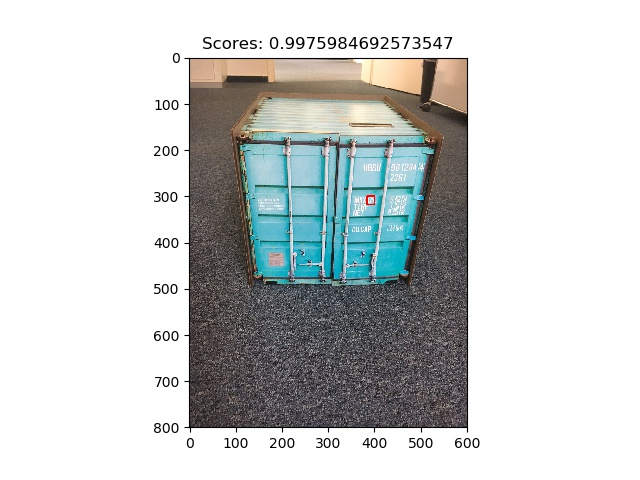

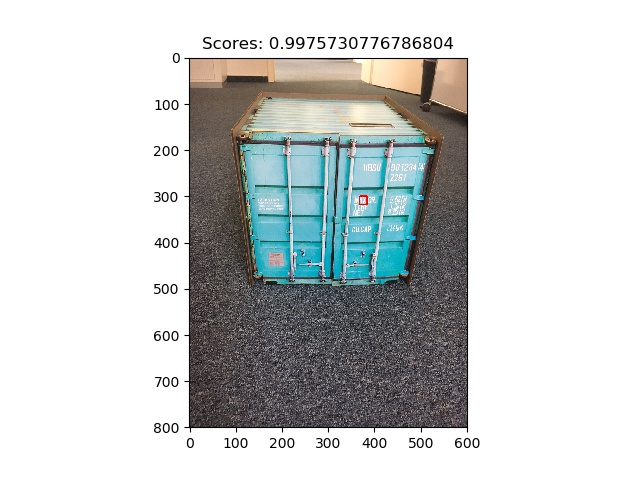

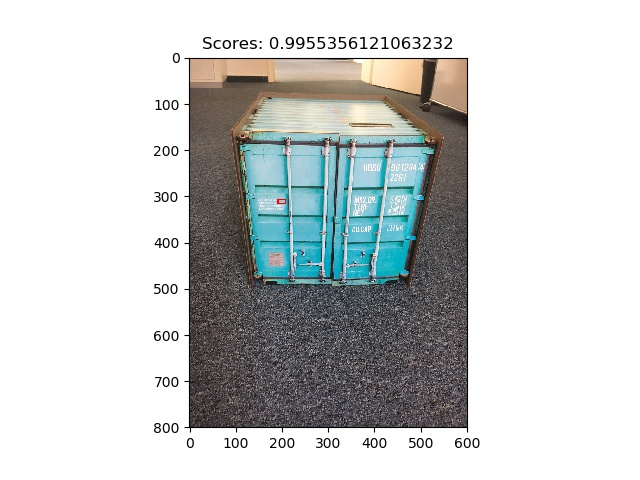

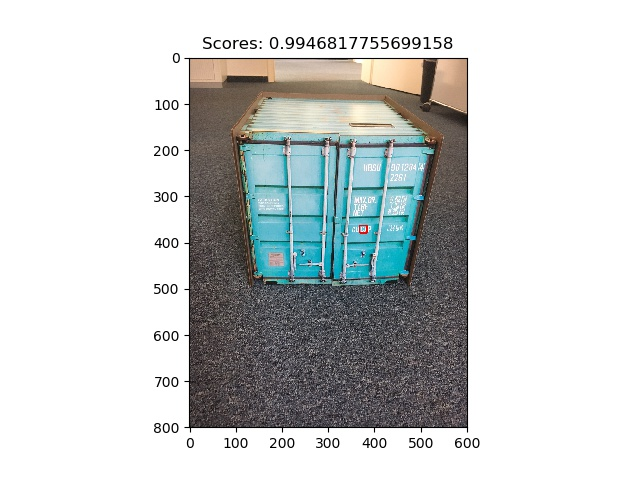

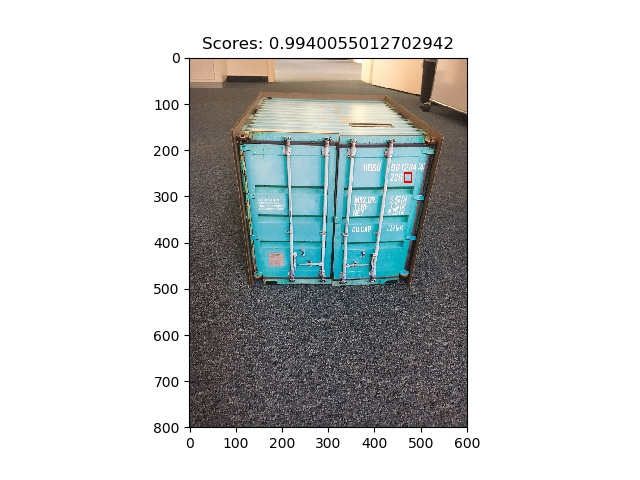

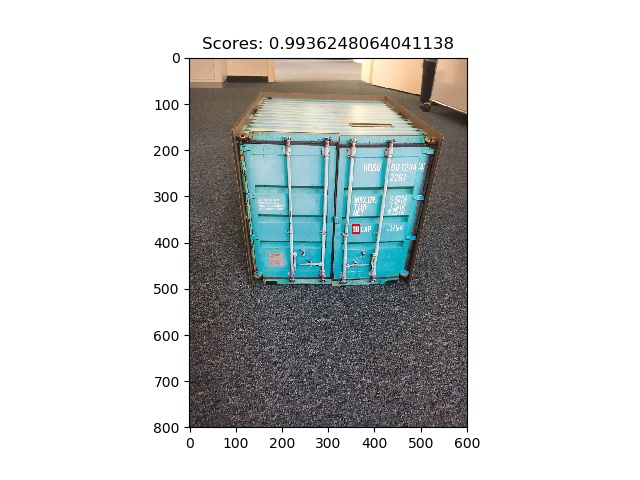

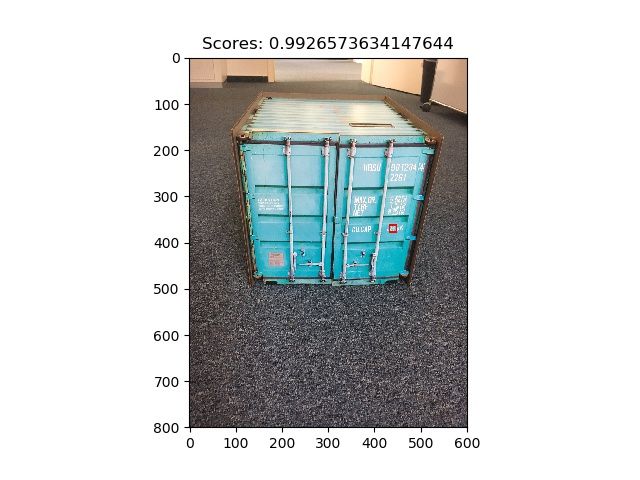

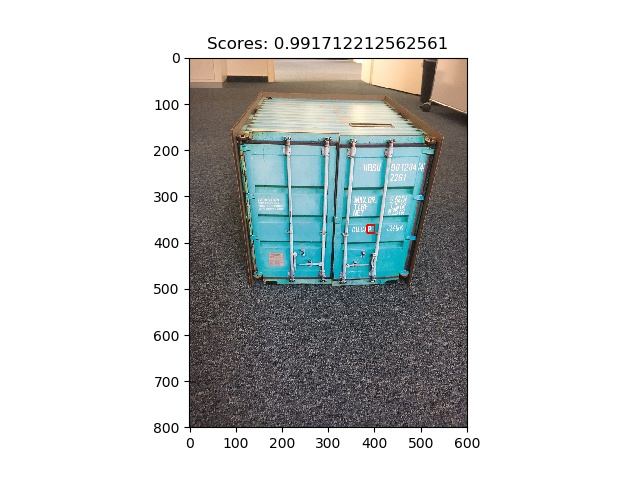

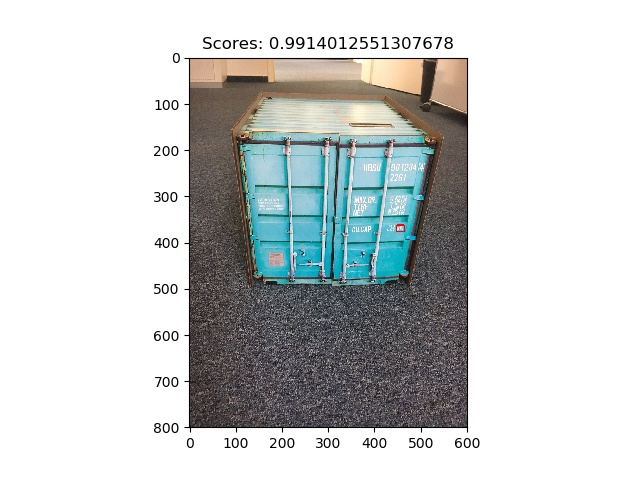

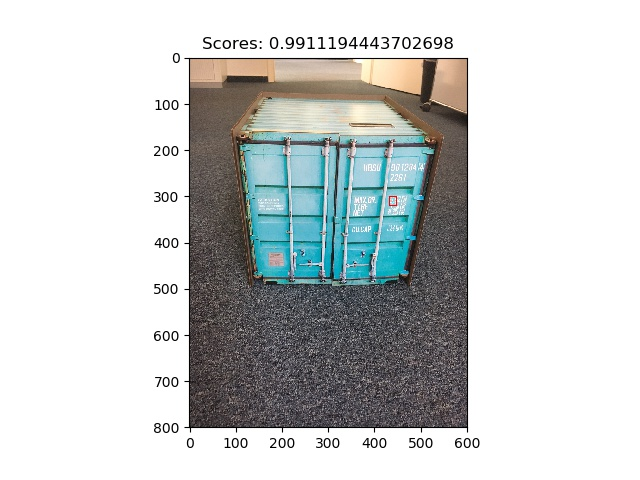

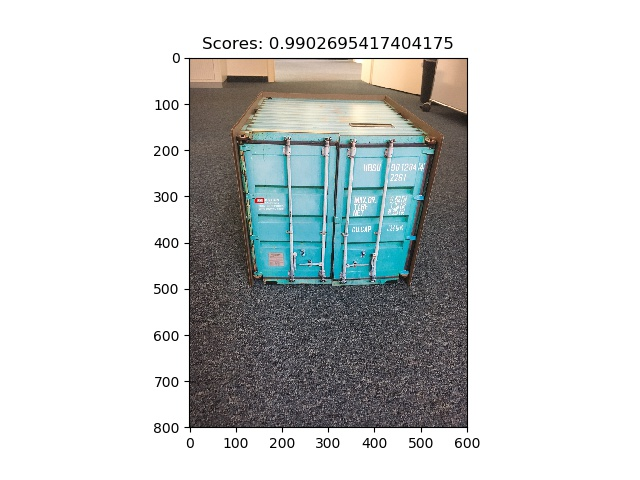

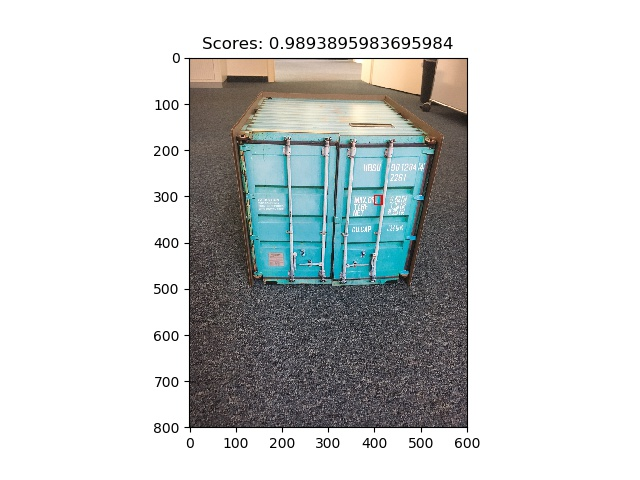

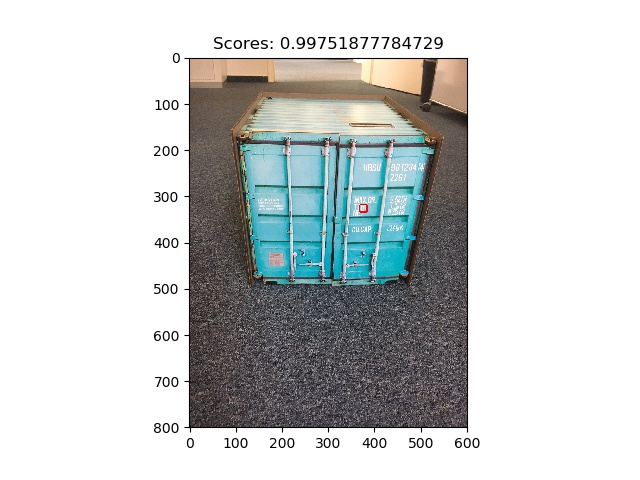

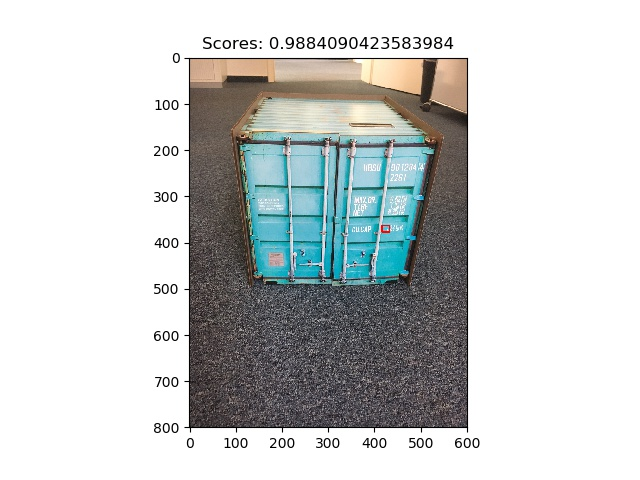

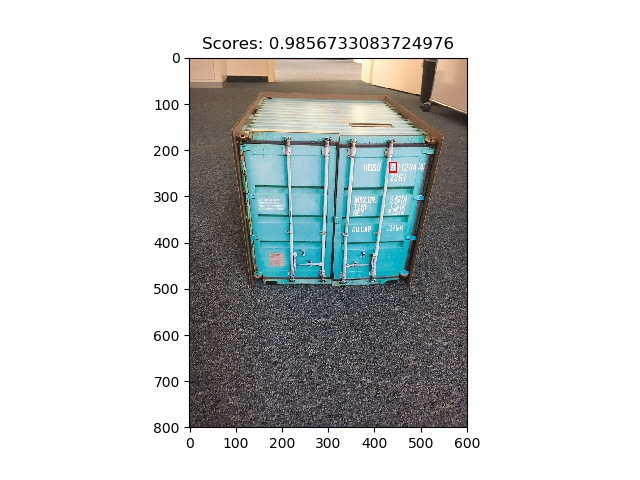

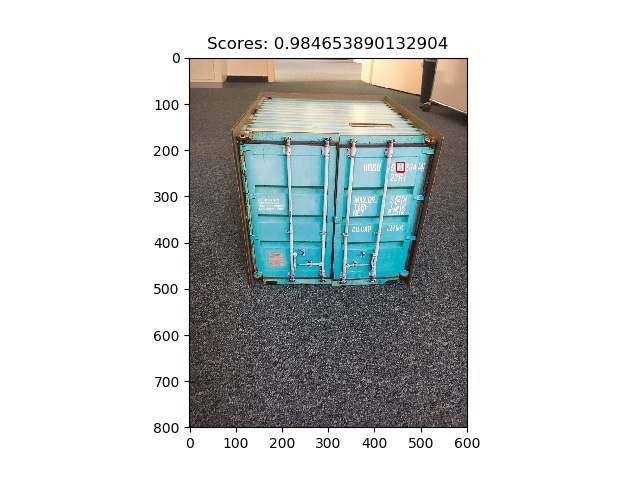

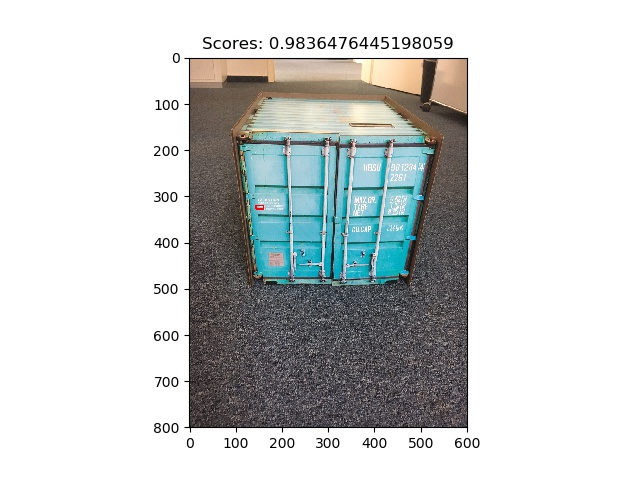

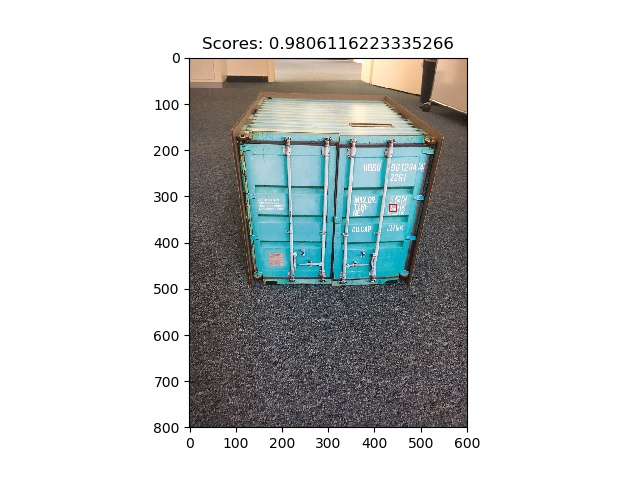

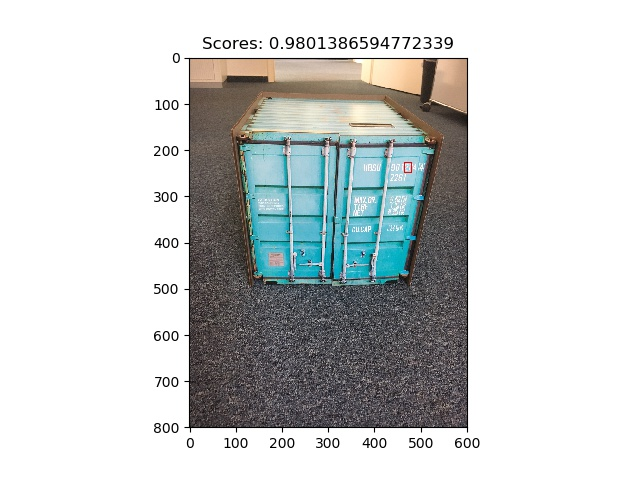

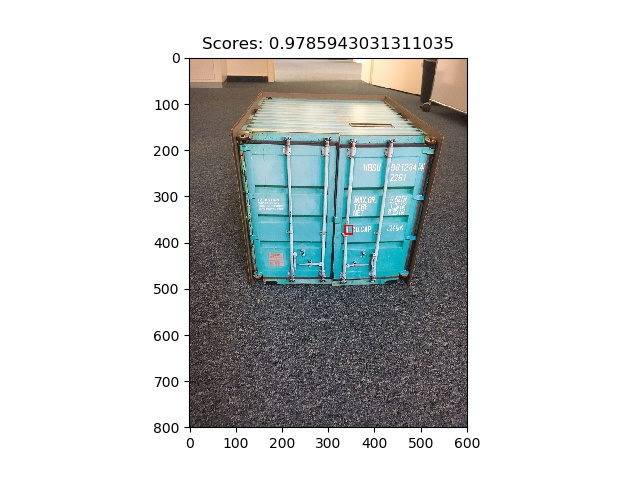

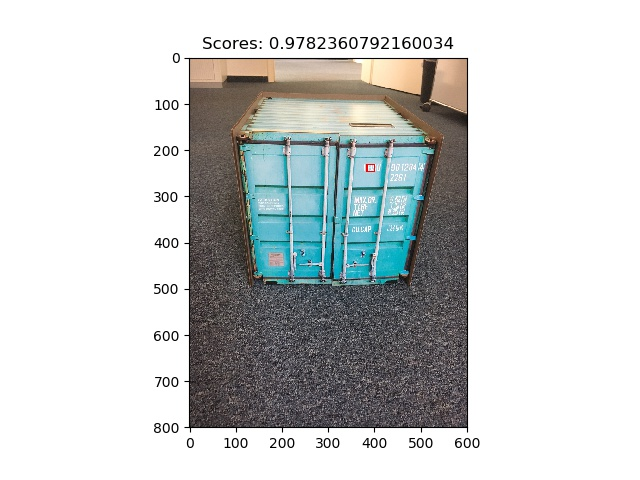

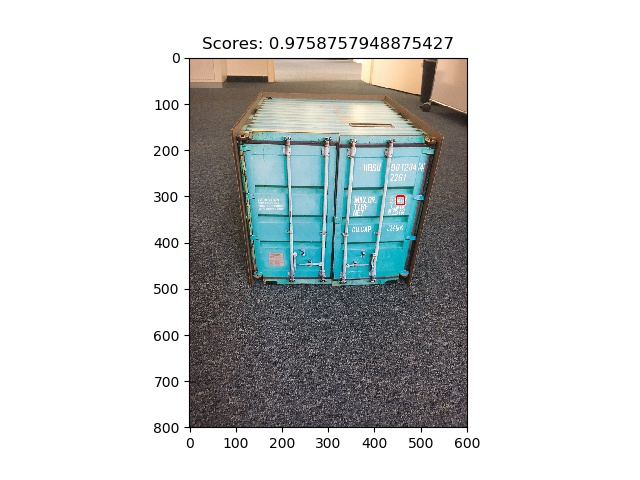

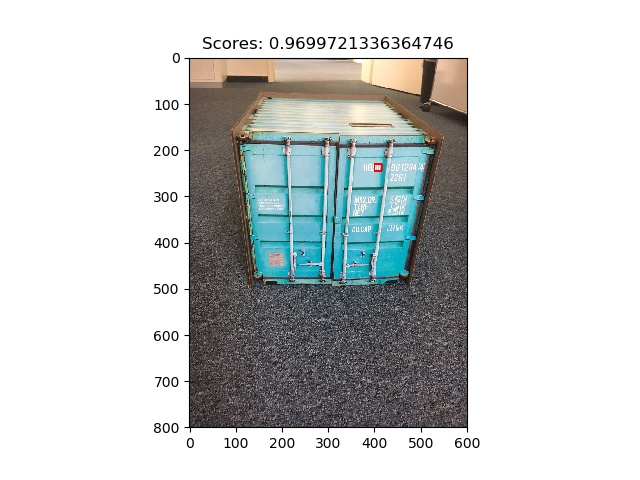

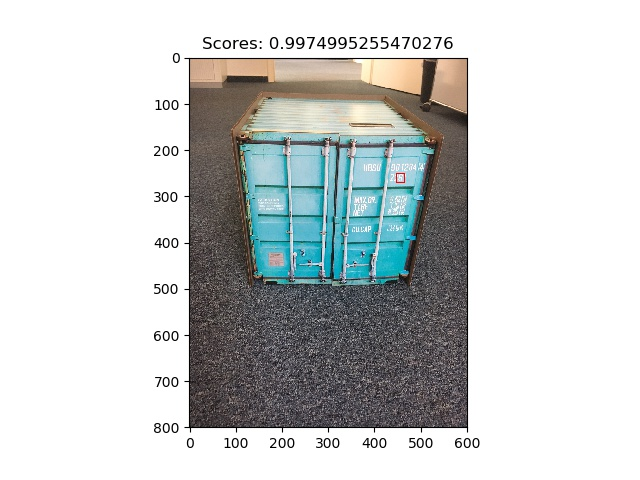

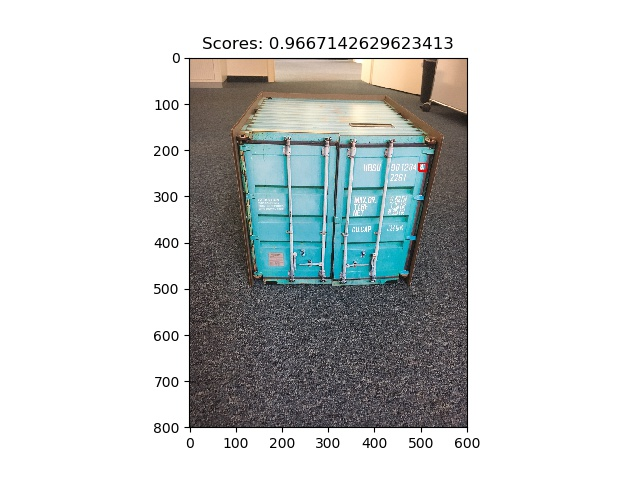

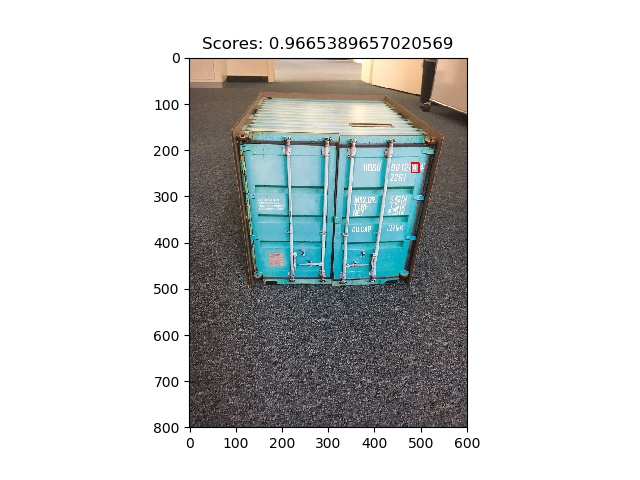

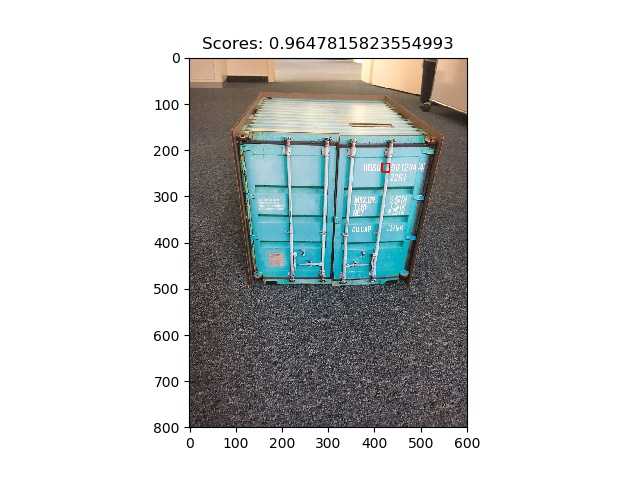

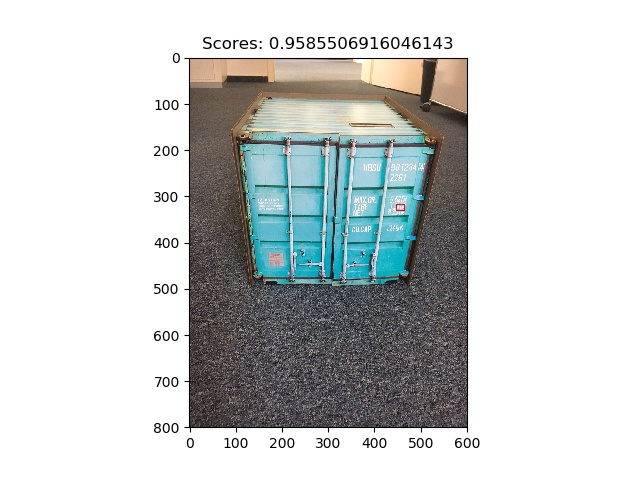

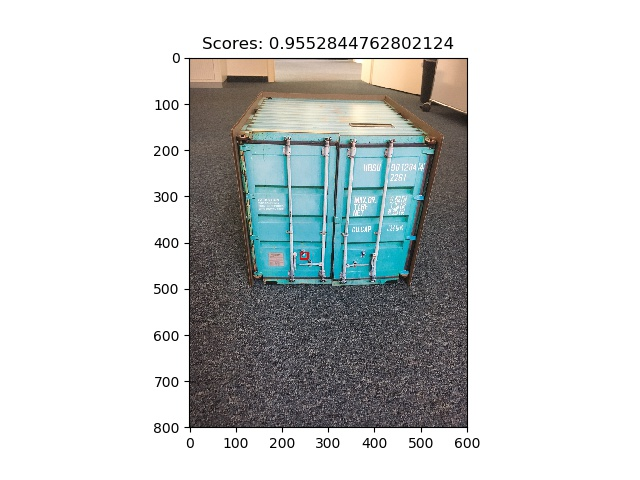

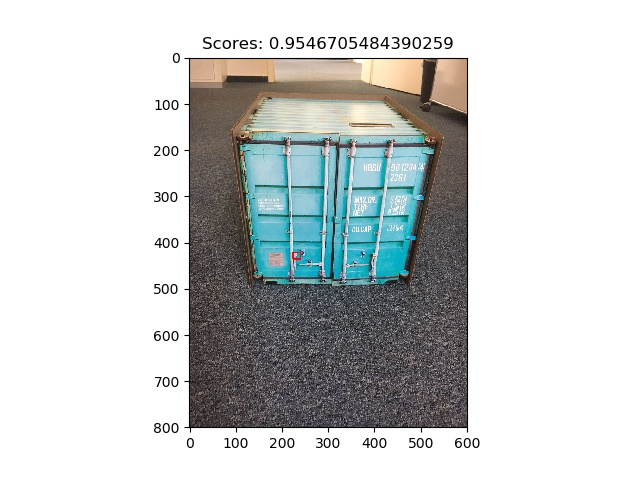

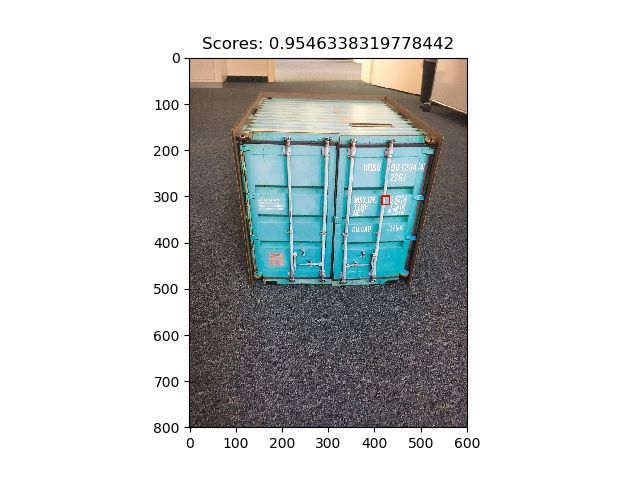

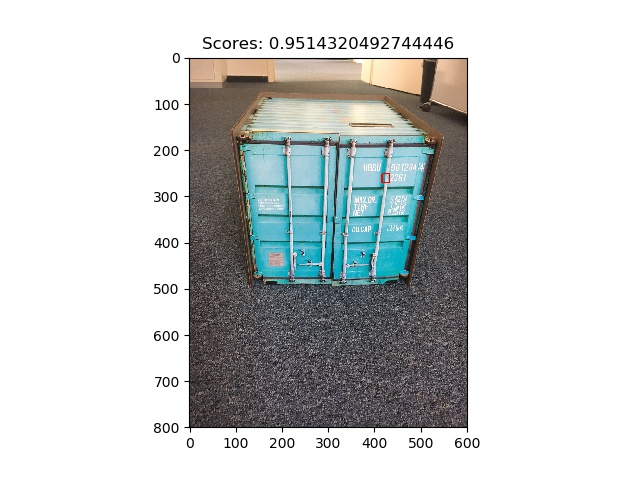

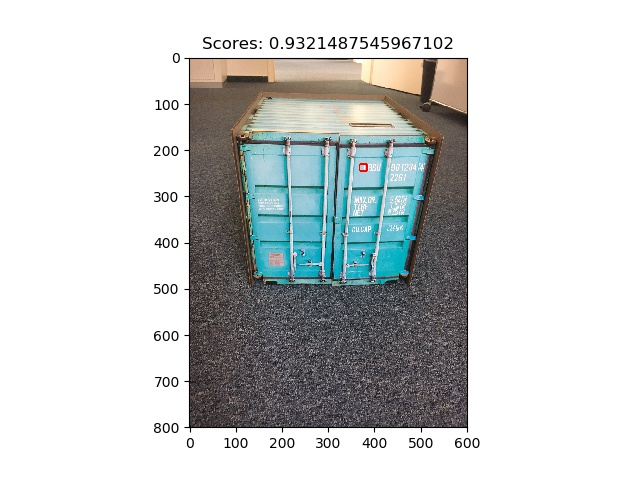

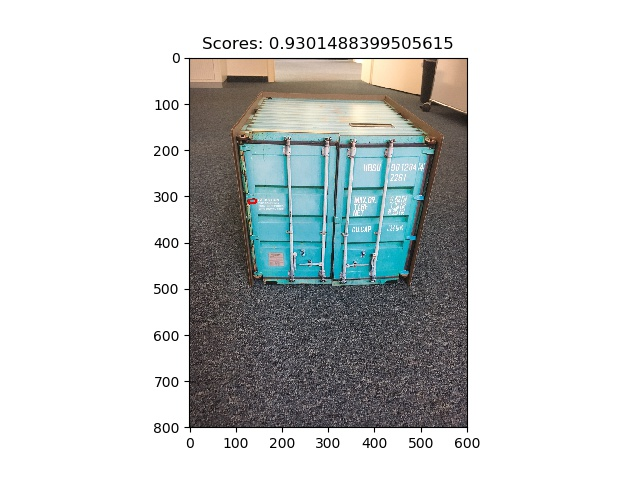

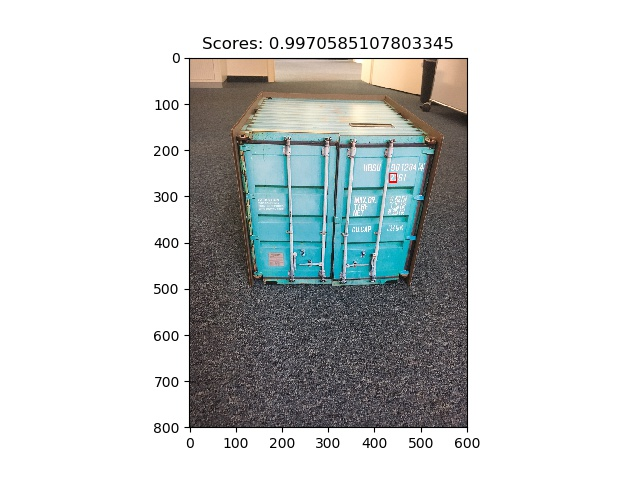

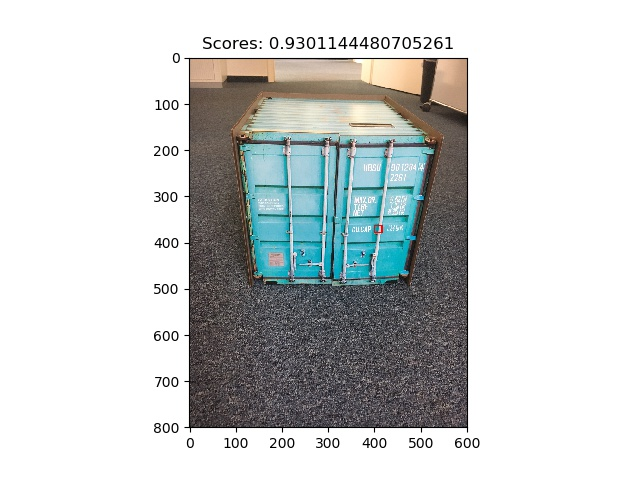

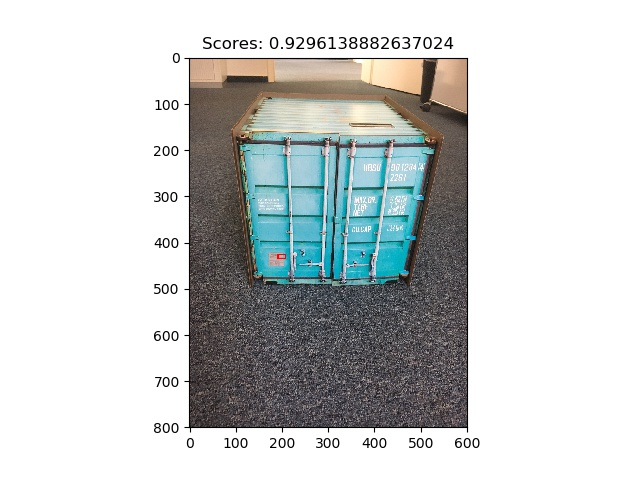

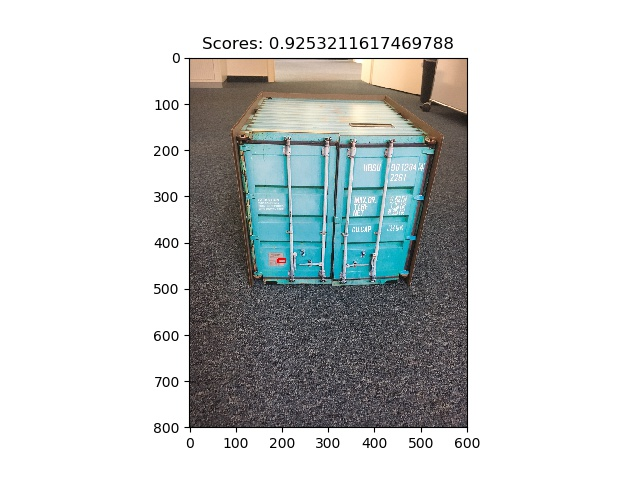

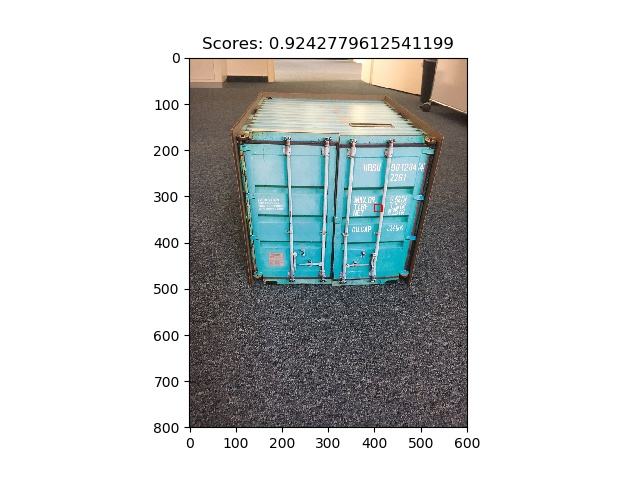

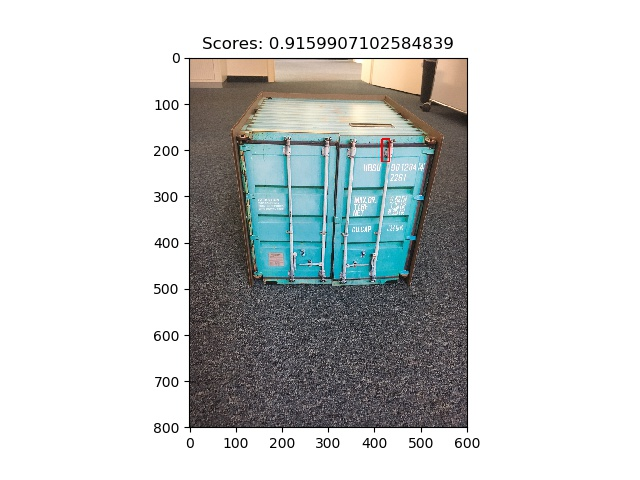

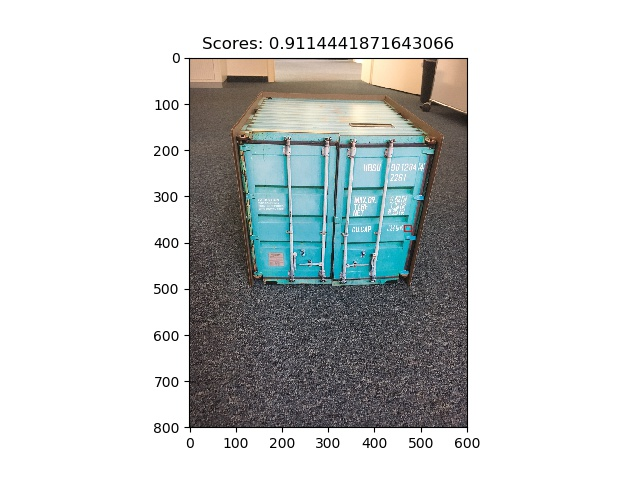

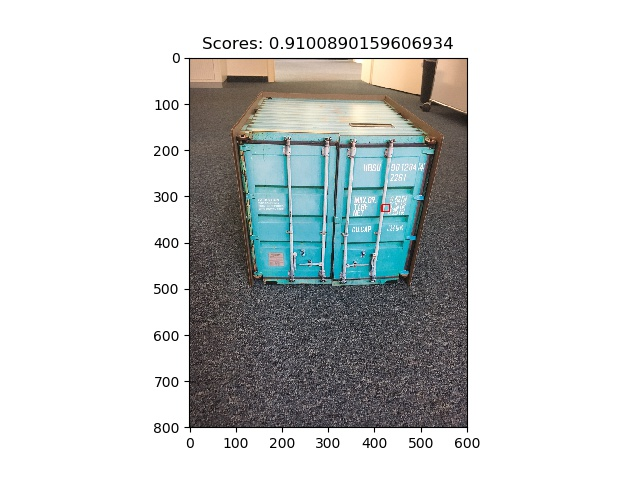

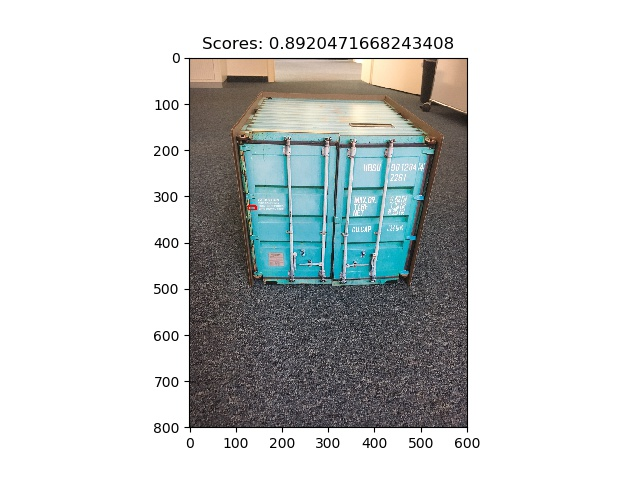

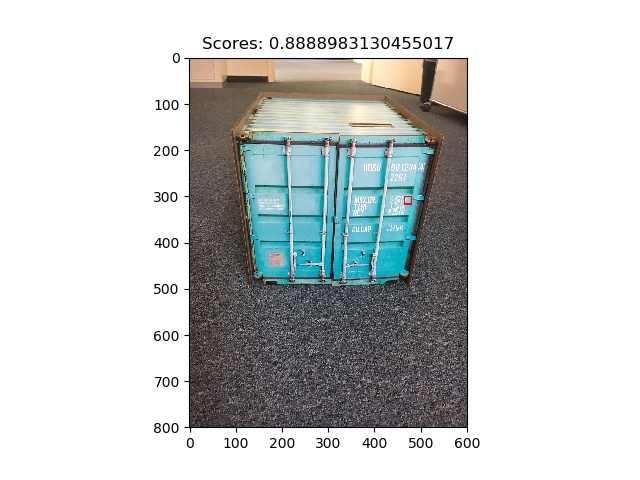

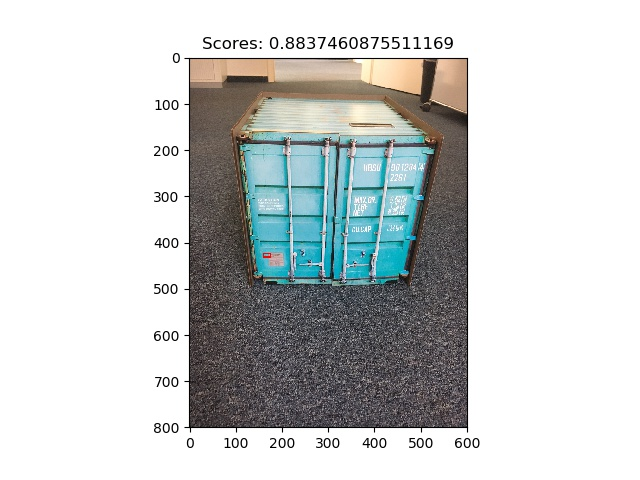

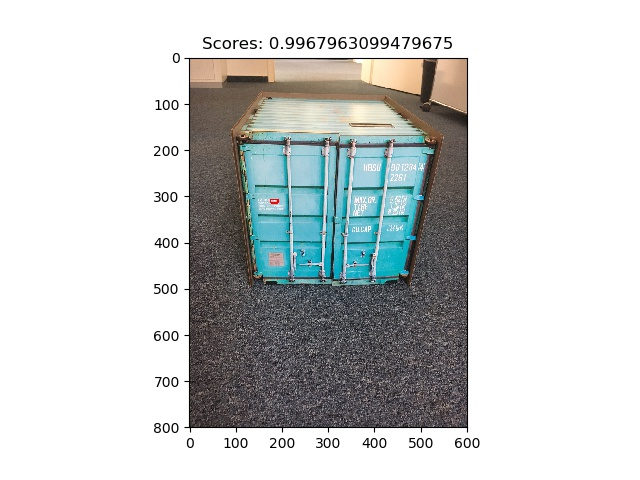

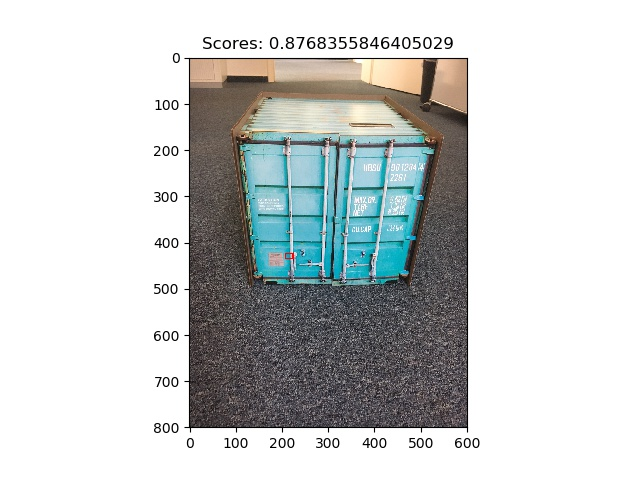

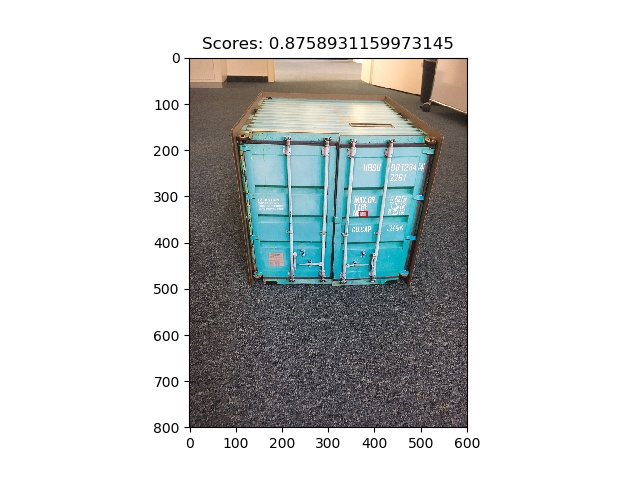

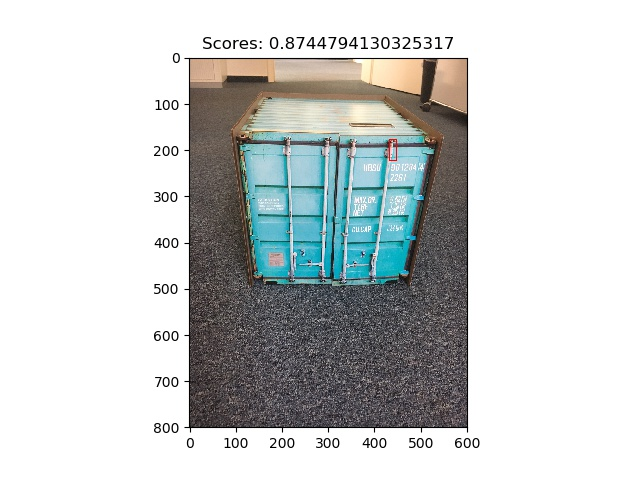

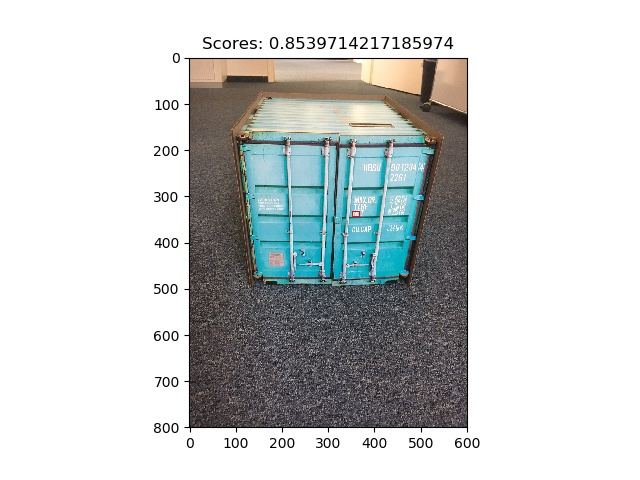

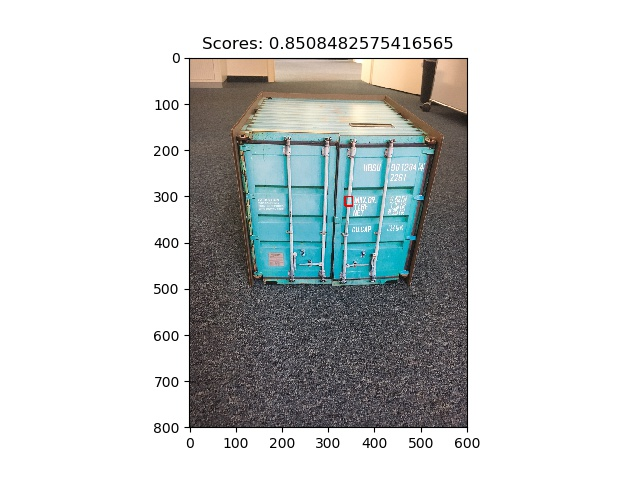

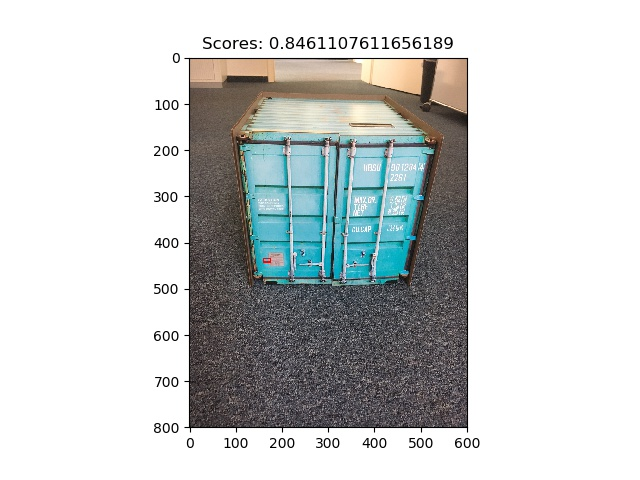

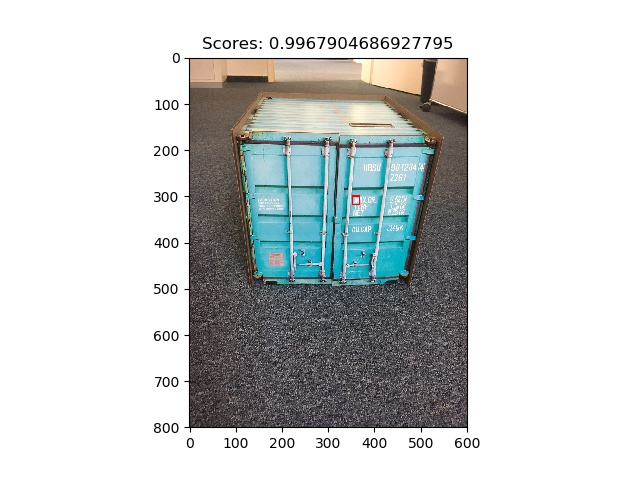

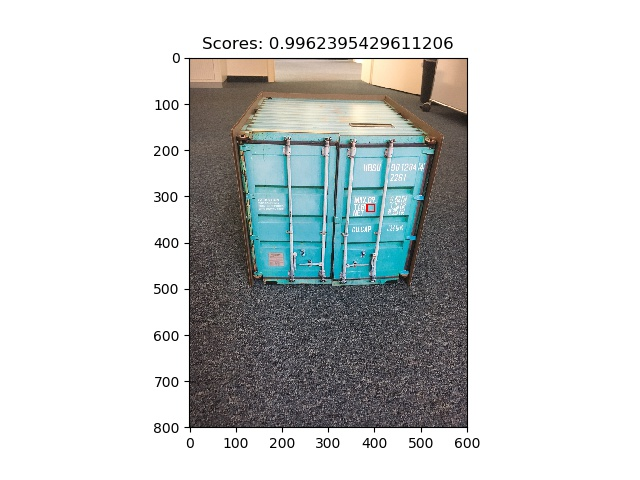

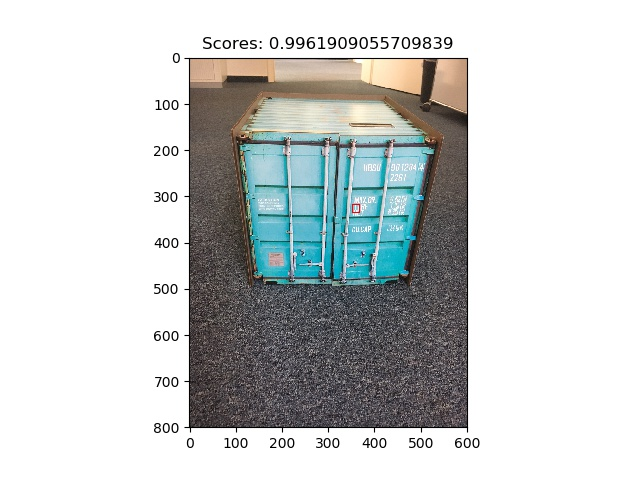

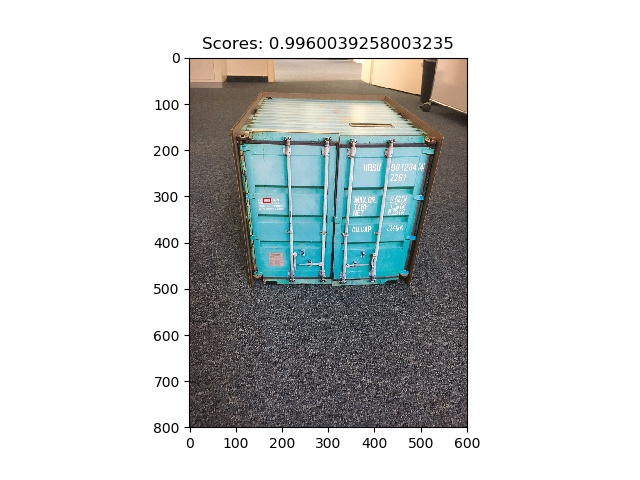

In [3]:
from IPython.display import Image
from IPython.display import display
import os

PATH = './data/fig'

fig_list = os.listdir(PATH)

for name in fig_list:
    x = Image(filename=PATH + '/' + name) 
    display(x)

### 边缘框的分数都很高，不能处理